# Implementing a Key-Value Database Using a Binary-Tree Structure

In this project, we'll use the binary-tree data structure as a building block for a fully functioning key-value store. 

A [key-value store](https://en.wikipedia.org/wiki/Key-value_database) is a database that operates similar to a Python dictionary. Our key-value store will work like a Python dictionary, but it will also allow users to perform range queries. Our goal will be to create an easy-to-use, flexible, and adaptable key value store that other developers could use in their projects.

There are multiple implementations of the key-value store used in production-grade systems worldwide. Some examples of open-source implementations are [Redis](https://redis.io/), [CouchDB](http://couchdb.apache.org/), [Mongo](https://www.mongodb.com/), and Cassandra (which uses a B-tree as the underlying data structure). These are just a few of the major projects that implement a key-value store similar to the one we'll be creating.

The first step is to import the `BTree` class and declare the `KVStore` class.

We'll fix the `split_threshold` to equal two. Doing so will make testing easier since we won't have to write tests for several different split threshold values.

## 1. Importing/building `BTree`, the binary-tree class

In [1]:
# Import libraries we'll use
import bisect
import pandas as pd
import random
import time
import csv
import matplotlib.pyplot as plt
import seaborn as sns

# Display graphs in notebook
%matplotlib inline

# Format graphs
sns.set(style='white', context='talk')
plt.style.use('dark_background')

from btree import BTree
# The script containing the binary tree class has has been imported from btree.py
# but it's implementation has been written out explicitly below

# Binary-tree complete node implementation
class Node:
    
    def __init__(self, keys=None, values=None, children=None, parent=None):
        self.keys = keys or []
        self.values = values or []
        self.parent = parent
        self.set_children(children)
        
    def set_children(self, children):
        self.children = children or []
        for child in self.children:
            child.parent = self
        
    def is_leaf(self):
        return len(self.children) == 0

    def contains_key(self, key):
        return key in self.keys
    
    def get_value(self, key):
        for i, k in enumerate(self.keys):
            if k == key:
                return self.values[i]
        return None
    
    def get_insert_index(self, key):
        return bisect.bisect(self.keys, key)
    
    def insert_entry(self, key, value):
        insert_index = self.get_insert_index(key)
        self.keys.insert(insert_index, key)
        self.values.insert(insert_index, value)
        return insert_index
    
    def split(self):
        if self.parent is None:
            return self.split_no_parent()
        return self.split_with_parent()
    
    def split_no_parent(self):
        split_index = len(self) // 2
        key_to_move_up = self.keys[split_index]
        value_to_move_up = self.values[split_index]
        
        # Create right node
        right_node = Node(
        self.keys[split_index+1:],
        self.values[split_index+1:],
        self.children[split_index+1:]
        )
        
        # Update left node (self)
        self.keys = self.keys[:split_index]
        self.values = self.values[:split_index]
        self.children = self.children[:split_index+1]
        
        # Create parent
        parent = Node([key_to_move_up], [value_to_move_up], [self, right_node])
        return parent
    
    def insert_child(self, insert_index, child):
        self.children.insert(insert_index, child)
        child.parent = self
    
    def split_with_parent(self):
        split_index = len(self) // 2
        key_to_move_up = self.keys[split_index]
        value_to_move_up = self.values[split_index]
        
        # Create right node
        right_node = Node(
        self.keys[split_index+1:],
        self.values[split_index+1:],
        self.children[split_index+1:]
        )
        
        # Update left node (self)
        self.keys = self.keys[:split_index]
        self.values = self.values[:split_index]
        self.children = self.children[:split_index+1]
        
        # Add new child to parent
        insert_index = self.parent.insert_entry(key_to_move_up, value_to_move_up)
        self.parent.insert_child(insert_index + 1, right_node)
        
        return self.parent

    def __len__(self):
        return len(self.values)

# Binary-tree implementation
class BTree:
    
    def __init__(self, split_threshold):
        self.root = Node()
        self.split_threshold = split_threshold
        self.height = 0
        self.size = 0
        
    def __len__(self):
        return self.size

    def _find_node(self, current_node, key):
        if current_node.contains_key(key):
            return current_node
        if current_node.is_leaf():
            return None
        child_index = current_node.get_insert_index(key)
        return self._find_node(current_node.children[child_index], key)
    
    def contains(self, key):
        node = self._find_node(self.root, key)
        if node is None:
            return False
        return True
    
    def _add(self, current_node, key, value):
        if current_node.is_leaf():
            current_node.insert_entry(key, value)
        else:
            child_index = current_node.get_insert_index(key)
            self._add(current_node.children[child_index], key, value)
        if len(current_node) > self.split_threshold:
            parent = current_node.split()
            if current_node == self.root:
                self.root = parent
                self.height += 1
                
    def add(self, key, value):
        self._add(self.root, key, value)
        self.size += 1
        
    def get_value(self, key):
        node = self._find_node(self.root, key)
        if node is None:
            return None
        return node.get_value(key)

## 2. Initializing the key-value store class

In [2]:
# Initializing KVStore class by extending the BTree class
class KVStore(BTree):
    
    def __init__():
        super().__init__(split_threshold=2)

## 3. Implementing the `add()` method

The `add()` method from the `BTree` class allows a user to add multiple entries with the same key. Since the `KVStore` extends the `BTree` class, the `add()` method from the `BTree` is automatically available in the `KVStore`. We don't want to have this behavior in the `KVStore`.

To fix this, we can declare a new method with the same name, `add`, inside the `KVStore`. This method will override the one from the `BTree`. The new method will now be the one that will be called.

The goal is to override the `add()` method and implement it so that it does the following:

* If the `key` was already added, then we get the node that contains it and replace the value associated with it by the new value. The `BTree` already has a `_find_node()` method that allows us to find a node containing a given key (if one exists).

* Otherwise, we add the new entry normally using the `add()` method from the `BTree`. To specify that we want to call the `add()` method from the `BTree` and not the one currently defined, we need to call it using the `super()` function, like so: `super().add()`.

In [3]:
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)
    
    # Implementing add() method
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            for i, node_key in enumerate(node.keys):
                if node_key == key:
                    node.values[i] = value

## 3.1 Testing initializing paramters and the `add()` method with assertions

It's a good idea to test the implementation as we go. Let's ensure that we can add values to the `KVStore` and that if we use repeated keys, the values get replaced.

A common way to test code is to use [unit tests](https://docs.python.org/3/library/unittest.html). We aren't going to use unit tests because they weren't really made to execute inside a notebook.

An alternative is to write some code and add [assertions](https://docs.pytest.org/en/stable/assert.html) that ensure that the state of the object is what it should be. An assertion is a Boolean expression that should be true. If it isn't, it will result in an exception, and we'll know something is wrong with our code.

In [4]:
# Instatiate the KVStore class
kvstore = KVStore()

# Test initialization
assert kvstore.split_threshold == 2, 'The split is not equal to 2.'

# Test that the value added is equal to the value retrieved
for i in range (1, 6):
    kvstore.add(i, i)
    assert kvstore.get_value(i) == i, 'The value, {}, added does not equal the value retrieved.'
    
# Test that the value updates if we add two entries with the same key and different values
kvstore.add(5, 10)
assert kvstore.get_value(5) == 10, 'The value did not update.'

## 4. Implementing dictionary syntax to retrieve and update values

We want to use the same syntax that dictionaries use, like so:

    kv = KVStore()
    kv[2] = 10
    print(kv[2])
    
    10
    

To do so, we need to implement the [`__getitem___()` method](https://docs.python.org/3/reference/datamodel.html?highlight=object%20__getitem__#object.__getitem__) and the [`__setitem__()` method](https://docs.python.org/3/reference/datamodel.html?highlight=object%20__setitem__#object.__setitem__). The `__getitem__()` method should call the get_value() method, and the `__setitem__()` should call the add() method.

In [5]:
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)
    
    # Implementing add() method
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            for i, node_key in enumerate(node.keys):
                if node_key == key:
                    node.values[i] = value
                    
    def __getitem__(self, key):
        return self.get_value(key)
    
    def __setitem__(self, key, value):
        self.add(key, value)

## 4.1 Testing dictionary bracket syntax

Let's run the same tests we did before but using the bracket syntax.

In [6]:
# Instatiate the KVStore class
kvstore = KVStore()

# Test that the value added is equal to the value retrieved using bracket syntax
for i in range (1, 6):
    kvstore[i] = i
    assert kvstore[i] == i, 'The value, {}, added does not equal the value retrieved.'
    
# Test that the value updates if we add two entries with the same key and different values
# using bracket syntax
kvstore[5] = 10
assert kvstore[5] == 10, 'The value did not update.'

## 4.3 Enabling the use of the `in` operator

Another nice feature of the dictionary is the ability to use the `in` operator to check whether a given key is stored.

To enable this operator on a custom class, we need to implement the [`__contains__()` method](https://docs.python.org/3/library/mailbox.html?highlight=__contains__#mailbox.Mailbox.__contains__) that checks whether a given key is contained in the data structure.

We already have a method called `contains()` inherited from the `BTree` class with that functionality. We can enable the `in` operator by implementing a method named `__contains__()` that calls the existing `contains()` method.

In [7]:
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)
    
    # Implementing add() method
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            for i, node_key in enumerate(node.keys):
                if node_key == key:
                    node.values[i] = value
                    
    def __getitem__(self, key):
        return self.get_value(key)
    
    def __setitem__(self, key, value):
        self.add(key, value)
        
    def __contains__(self, key):
        return self.contains(key)

## 4.4 Testing the `in` operator

Let's see if we can use the `in` operator on an instance of `KVStore`.

In [8]:
# Instatiate the KVStore class
kvstore = KVStore()

# Test that that the `in` operator is operational using strings as keys
for character in 'abcdefg':
    kvstore[character] = character
    assert kvstore[character] == character, 'Using strings as keys and values did not work.'
    
for character in 'abcdefg':
    assert character in kvstore, 'The `in` operator is not functional.'

## 5. Implementing range queries

So far, we've implemented the same functionality as a dictionary. Now it is time to make it more powerful by implementing range queries.

In [9]:
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)
    
    # Implementing add() method
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            for i, node_key in enumerate(node.keys):
                if node_key == key:
                    node.values[i] = value
                    
    def __getitem__(self, key):
        return self.get_value(key)
    
    def __setitem__(self, key, value):
        self.add(key, value)
        
    def __contains__(self, key):
        return self.contains(key)
    
    def _range_query(self, range_start, range_end, current_node, min_key, max_key):
        if not self._range_intersects(range_start, range_end, min_key, max_key):
            return []
        results = []
        for i, key in enumerate(current_node.keys):
            if range_start <= key and key <= range_end:
                results.append(current_node.values[i])
        if not current_node.is_leaf():
            for i, child in enumerate(current_node.children):
                new_min_key = current_node.keys[i - 1] if i > 0 else min_key
                new_max_key = current_node.keys[i] if i < len(current_node) else max_key
                results += self._range_query(range_start, range_end, child, new_min_key, new_max_key)
        return results 

    def range_query(self, range_start, range_end):
        return self._range_query(range_start, range_end, self.root, None, None)
    
    def _range_intersects(self, range_start, range_end, node_min, node_max):
        if node_min is not None and node_min > range_end:
            return False
        if node_max is not None and node_max < range_start:
            return False
        return True

## 5.1 Testing range query method

 When we're dealing with data structures, one way to test them is to compare them with a simpler implementation that we know is correct. We perform the same operations on both and see if both provide the same results.
 
 Here's an implementation of a key-value store that uses a dictionary as the base data structure.
 
    class DictKVStore(dict):

        def range_query(self, range_start, range_end):
            result = []
            for key in self.keys():
                if range_start <= key and key <= range_end:
                    result.append(self[key])
            return result
            
We'll use this to test our implementation.

In [10]:
class DictKVStore(dict):

    def range_query(self, range_start, range_end):
        result = []
        for key in self.keys():
            if range_start <= key and key <= range_end:
                result.append(self[key])
        return result

In [11]:
# Testing if both data structures return the same range query result
dict_kv = DictKVStore()
our_kv = KVStore()
for i in range(10):
    dict_kv[i] = i
    our_kv[i] = i

for range_start, range_end in [(1, 3), (4, 6), (1, 10), (5, 5)]:
    dict_res = sorted(dict_kv.range_query(range_start, range_end))
    our_res = sorted(our_kv.range_query(range_start, range_end))
    assert dict_res == our_res, "Both data structures do not return the same range query result."

In [12]:
# Testing if both data structures return the same range query result using strings
dict_kv = DictKVStore()
our_kv = KVStore()
for character in 'abcdefg':
    dict_kv[character] = character
    our_kv[character] = character

for range_start, range_end in [('a', 'c'), ('d', 'f'), ('a', 'g'), ('e', 'e')]:
    dict_res = sorted(dict_kv.range_query(range_start, range_end))
    our_res = sorted(our_kv.range_query(range_start, range_end))
    assert dict_res == our_res, "Both data structures do not return the same range query result."

## 5.2 Testing the range query on larger, random sets of key-value pairs

This testing above is using hard-coded values. We'll generate random values instead by using the `random` module.

In [13]:
random.seed(0)

NUM_INSERTS = 100
NUM_CONTAINS = 100
NUM_RANGE_QUERIES = 100

dict_kv = DictKVStore()

kv = KVStore()

print("Testing Insertion")
for _ in range(NUM_INSERTS):
    key = random.randint(0, 100)
    value = random.randint(0, 1000000)
    dict_kv[key] = value
    kv[key] = value
    
print("Testing Length")
assert len(dict_kv) == len(kv), "Wrong length. Length should be {} but is {}.".format(len(dict_kv), len(kv))
    

print("Testing Values")
for key in dict_kv:
    assert dict_kv[key] == kv[key], "Wrong value for key {}. Expected value {} but found value {}.".format(key, dict_kv[key], kv[key])

    
print("Testing in Operator")
for i in range(NUM_CONTAINS):
    key = random.randint(0, 1000)
    assert (key in dict_kv) == (key in kv), "Contains method did not return the correct value for key {}.".format(key)


print("Testing Range Queries")
for _ in range(NUM_RANGE_QUERIES):
    range_start = random.randint(0, 100)
    range_end = random.randint(range_start, 100)
    dict_results = dict_kv.range_query(range_start, range_end)
    kv_results = kv.range_query(range_start, range_end)
    assert len(dict_results) == len(kv_results), "Wrong number of reuslt in range query [{}, {}]. Should be {} but was {}.".format(range_start, range_end, len(dict_result), len(kv_result))
    dict_results.sort()
    kv_results.sort()
    assert dict_results == kv_results, "Wrong number of reuslt in range query [{}, {}]. Should be {} but was {}.".format(range_start, range_end, len(dict_result), len(kv_result))

Testing Insertion
Testing Length
Testing Values
Testing in Operator
Testing Range Queries


## 6. Testing performance

The `DictKVStore` class provided a very concise implementation of a key-value store based on a dictionary.

Why did we go through all the trouble of implementing B-trees and the `KVStore` class when a much simpler implementation is possible? The reason is the performance of range queries.

There are several ways we can compare the performance of both data structures. The overall idea is as follows:

1. Generate many entries (about 50,000 should be enough).
2. Generate many query intervals. It's better to generate query intervals in a way that increases the number of query results from 1 to some given value. This way, we can see the impact of the number of results in the performance gained.
3. For each query, compute the ratio between the runtime using the dictionary-based implementation and the B-tree-based implementation. A ratio of 1 means that both took the same time, a ratio of 2 means that the B-tree implementation was two times faster, and so on.
4. Plot the runtime ratios to better visualize the results.

Pre-generated test data can be found in the files, `entries.csv`, which contains a list of 50,000 entries, and the `queries.csv` file, which contains a list of 1,000 queries with results ranges from 1 to 1,000.

In [14]:
# Generate 100,000 entries and queries
random.seed(0)
key_values = [[random.randint(1, 100000), random.randint(1, 100000)] for _ in range(100000)]

range_start = [random.randint(1, 100000) for _ in range(100000)]

range_end = [random.randint(start, 100000) for start in range_start]

range_queries = [[start, end] for start, end in zip(range_start, range_end)]

In [15]:
dict_kv = DictKVStore()
kvstore = KVStore()

# Load the entries
with open('entries.csv', 'r') as f:
    rows = list(csv.reader(f))[1:]
    for row in rows:
        key = int(row[0])
        value = int(row[1])
        dict_kv[key] = value
        kvstore[key] = value

# Measure query times
time_ratios = []
with open('queries.csv', 'r') as f:
    rows = list(csv.reader(f))[1:]
    for row in rows:
        range_start = int(row[0])
        range_end = int(row[1])
        
        start = time.time()
        dict_kv.range_query(range_start, range_end)
        end = time.time()
        time_dict = end - start

        start = time.time()
        kvstore.range_query(range_start, range_end)
        end = time.time()
        time_kv = end - start

        time_ratios.append(time_dict / time_kv)

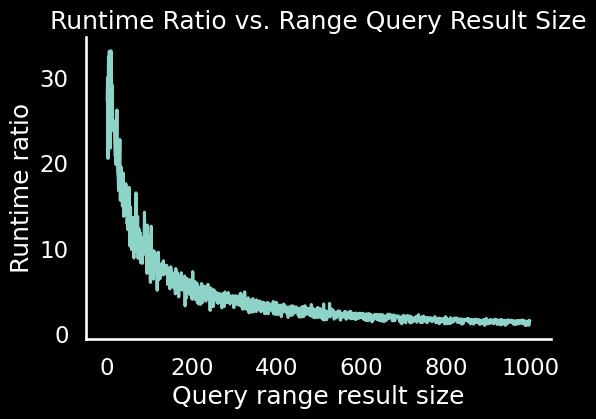

In [16]:
# Plot results
plt.plot(time_ratios)
plt.title('Runtime Ratio vs. Range Query Result Size')
plt.xlabel('Query range result size')
plt.ylabel('Runtime ratio')
sns.despine()
plt.show();

Each data structure contains 50,000 entries. For range queries returning only a few results, we get a performance boost of at most 40 times.

We see that the performance boost decreases as the size of the of query increases. This is expected since the more result we return the closer we get to having to iterate of all entries in the tree.

## 6.1 Performance testing using randomly generated data

In [44]:
# Generate 100,000 entries and 1,000 queries
random.seed(1)
key_values = [[random.randint(1, 100000), random.randint(1, 100000)] for _ in range(100000)]

range_start = [random.randint(1, 100000) for _ in range(1000)]

range_end = [random.randint(random.sample(range_start, 1)[0], 100000) for _ in range(1000)]

range_queries = [(start, end) for start, end in zip(range_start, range_end)]

In [45]:
dict_kv = DictKVStore()
kvstore = KVStore()

# Load entries into each data structure
for key, value in key_values:
    dict_kv[key] = value
    kvstore[key] = value   

In [46]:
# Measure query times
time_ratios_result_size = {}
for range_start, range_end in range_queries:
    
    start = time.time()
    result_size = len(dict_kv.range_query(range_start, range_end))
    end = time.time()
    time_dict = end - start

    start = time.time()
    result_size = len(kvstore.range_query(range_start, range_end))
    end = time.time()
    time_kv = end - start

    time_ratios_result_size[result_size] = time_dict / time_kv

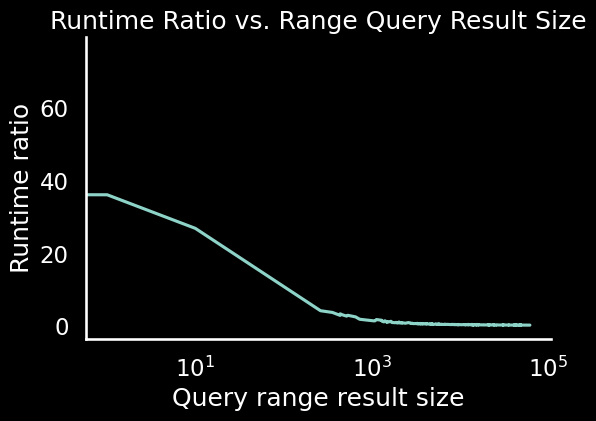

In [49]:
# Plot results
sorted_results = sorted(time_ratios_result_size.items())
plt.semilogx([x for x, y in sorted_results], [y for x, y in sorted_results])
plt.title('Runtime Ratio vs. Range Query Result Size')
plt.xlabel('Query range result size')
plt.ylabel('Runtime ratio')
sns.despine()
plt.show();

## Conclusion

We used the binary-tree data structure as a building block for a fully functioning key-value store.

We compared the range query performance to that of a simple hash table (dictionary) range query function, `DictKVStore`, and found:
* A performance boost of up to 40 times when range queries returned a small number of results using datastores with 50,000 entries and ordered data.
* A performance boost


### Next steps

There are many other things that you could implement if you want to improve the KVStore implementation. Here are a few ideas:

* Implement the `__iter__()` method to make it iterable. With this method, users will be able to iterate over all keys using `for key in kv:`, where kv in an instance of `KVStore`.

* Implement the `save()` and `load()` method to save and load the `KVStore` into a file.

* Make each node keep track of the number of keys it stores in its subtree. Use that to implement a `range_count()` method that counts the number of entries in a range. It's possible to make this query run in `O(log(n))` time.

* Implement a B+ tree to replace the underlying b-tree.